# Rupaul's Drag Race Machine

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd
import numpy as np
import math, random
from scipy.stats import rankdata, kendalltau
from sklearn.preprocessing import scale

theData = pd.read_csv("dragrace10.csv")
theData= theData.fillna(0)

/Users/literroy/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
queens = theData.groupby('Name').max()
queens = queens.reset_index(drop=False)
#queens.iloc[1:10,:]

In [3]:
# create a function to scale the data for us
def scaleQueens(df):
    """Scale Age, Wins, Highs, Lows, and Lipsyncs in feature data frames"""
    df = df.copy(deep=True)
    df['Age'] = scale(df['Age'])
    df['Wins'] = scale(df['Wins'])
    df['Highs'] = scale(df['Highs'])
    df['Lows'] = scale(df['Lows'])
    df['Lipsyncs'] = scale(df['Lipsyncs'])
    df['Season'] = df['Season']/8
    return df

In [4]:
def compareRanks(x,y):
    x=np.asarray(x)
    y=np.asarray(y)
    numRanks = np.append(x,y).max()
    actual=np.sum(np.square(x-y))
    worst=np.sum(np.square(np.sort(x)-np.sort(x)[::-1]))
    return 1-2*(actual/worst)

In [5]:
def createPD(s,queens,yfitpd):
    season = queens.loc[queens.Season==s,['Name','Place']]
    seasonpred = yfitpd.loc[queens.Season==s]
    season['Predicted'] = seasonpred
    season['Predicted'] = rankdata(season.Predicted,method='min')
    season = season.sort_values('Place')
    return season

In [6]:
def predictSeason(season,model,queens,scaled=False):
    Xtrain = queens.loc[queens.Season!=season,['Age','PuertoRico','PlusSize','Wins','Highs','Lows','Lipsyncs','Season']]
    Xtest = queens.loc[queens.Season==season,['Age','PuertoRico','PlusSize','Wins','Highs','Lows','Lipsyncs','Season']]
    ytrain = queens.loc[queens.Season!=season,'Place']
    if scaled:
        Xtrain = scaleQueens(Xtrain)
        Xtest = scaleQueens(Xtest)
    model.fit(Xtrain,ytrain)
    yfit = model.predict(Xtest)
    pddf = queens.loc[queens.Season==season,['Name','Place']]
    pddf['Predicted'] = rankdata(yfit,method='min')
    return pddf

In [7]:
def setXY(x,y,n):
    """Get appropriate x,y coords in cases of ties"""
    y = y - int((n-1)/3)*0.8
    if n % 3 == 2:
        x = x - 0.33
    elif n % 3 == 0:
        x = x + 0.33
    return(x,y)

# Predict All Stars

In [8]:
# create series with names of all star queens
allstars = pd.Series(["Monet x Change","Latrice Royale","Trinity Taylor","Farrah Moan",
                     "Valentina","Monique Heart","Jasmine Masters","Naomi Smalls","Gia Gunn",
                     "Manila Luzon"])
allstars

0     Monet x Change
1     Latrice Royale
2     Trinity Taylor
3        Farrah Moan
4          Valentina
5      Monique Heart
6    Jasmine Masters
7       Naomi Smalls
8           Gia Gunn
9       Manila Luzon
dtype: object

In [9]:
names = queens.Name
mask = names.isin(allstars)
Xtest = queens.loc[mask,['Age','PuertoRico','PlusSize','Wins','Highs','Lows','Lipsyncs','Season']]
ytest = queens.loc[mask,'Place']

Xtrain = queens.loc[~mask,['Age','PuertoRico','PlusSize','Wins','Highs','Lows','Lipsyncs','Season']]
ytrain = queens.loc[~mask,'Place']

In [10]:
AllStars = queens.loc[mask,['Name','Season','Place']]
AllStars

,Name,Season,Place
32,Farrah Moan,9,8
33,Gia Gunn,6,10
41,Jasmine Masters,7,12
60,Latrice Royale,4,4
64,Manila Luzon,3,2
73,Monet x Change,10,6
75,Monique Heart,10,8
79,Naomi Smalls,8,3
114,Trinity Taylor,9,4
117,Valentina,9,7


In [11]:
XtrainS = scaleQueens(Xtrain)
XtestS = scaleQueens(Xtest)

/Users/literroy/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [12]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier

svc_model = SVC(kernel='rbf',gamma=0.01,C=10)
gnb_model = GaussianNB()
rfc_model = RandomForestClassifier(n_estimators=100, random_state=0)
rfr_model = RandomForestRegressor(200,random_state=24601)
nn2_model=MLPClassifier(hidden_layer_sizes=(5,10),
                       activation='logistic',
                       solver='lbfgs',
                       random_state=24601)

/Users/literroy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [14]:
predictSeason(9,nn2_model,queens,True)

/Users/literroy/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


,Name,Place,Predicted
10,Aquaria,1,3
11,Asia O’Hara,4,1
15,Blair St. Clair,9,10
30,Dusty Ray Bottoms,11,8
31,Eureka,11,1
48,Kalorie Karbdashian Williams,13,9
49,Kameron Michaels,3,3
67,Mayhem Miller,10,14
72,Miz Cracker,5,3
73,Monet x Change,6,3


# Support Vector Classifier

In [15]:
svc_model.fit(XtrainS,ytrain)
yfit = svc_model.predict(XtestS)
AllStars['SVC'] = rankdata(yfit,method='min')
AllStars

,Name,Season,Place,SVC
32,Farrah Moan,9,8,4
33,Gia Gunn,6,10,10
41,Jasmine Masters,7,12,9
60,Latrice Royale,4,4,3
64,Manila Luzon,3,2,1
73,Monet x Change,10,6,5
75,Monique Heart,10,8,6
79,Naomi Smalls,8,3,6
114,Trinity Taylor,9,4,2
117,Valentina,9,7,6


# Gaussian Naive Bayes

In [16]:
gnb_model.fit(Xtrain,ytrain)
yfit = gnb_model.predict(Xtest)
AllStars['GNB'] = rankdata(yfit,method='min')
AllStars

,Name,Season,Place,SVC,GNB
32,Farrah Moan,9,8,4,7
33,Gia Gunn,6,10,10,10
41,Jasmine Masters,7,12,9,7
60,Latrice Royale,4,4,3,6
64,Manila Luzon,3,2,1,1
73,Monet x Change,10,6,5,5
75,Monique Heart,10,8,6,7
79,Naomi Smalls,8,3,6,1
114,Trinity Taylor,9,4,2,1
117,Valentina,9,7,6,1


# Random Forest Classifier

In [17]:
rfc_model.fit(Xtrain,ytrain)
yfit = rfc_model.predict(Xtest)
AllStars['RFC'] = rankdata(yfit,method='min')
AllStars

,Name,Season,Place,SVC,GNB,RFC
32,Farrah Moan,9,8,4,7,5
33,Gia Gunn,6,10,10,10,9
41,Jasmine Masters,7,12,9,7,10
60,Latrice Royale,4,4,3,6,3
64,Manila Luzon,3,2,1,1,1
73,Monet x Change,10,6,5,5,4
75,Monique Heart,10,8,6,7,8
79,Naomi Smalls,8,3,6,1,5
114,Trinity Taylor,9,4,2,1,1
117,Valentina,9,7,6,1,5


# Random Forest Regressor

In [18]:
rfr_model.fit(Xtrain,ytrain)
yfit = rfr_model.predict(Xtest)
AllStars['RFR'] = rankdata(yfit,method='min')
AllStars

,Name,Season,Place,SVC,GNB,RFC,RFR
32,Farrah Moan,9,8,4,7,5,6
33,Gia Gunn,6,10,10,10,9,10
41,Jasmine Masters,7,12,9,7,10,9
60,Latrice Royale,4,4,3,6,3,3
64,Manila Luzon,3,2,1,1,1,1
73,Monet x Change,10,6,5,5,4,7
75,Monique Heart,10,8,6,7,8,8
79,Naomi Smalls,8,3,6,1,5,4
114,Trinity Taylor,9,4,2,1,1,2
117,Valentina,9,7,6,1,5,5


# Neural Network

In [19]:
nn2_model.fit(XtrainS,ytrain)
yfit = nn2_model.predict(XtestS)
AllStars['NN'] = rankdata(yfit,method='min')
AllStars

,Name,Season,Place,SVC,GNB,RFC,RFR,NN
32,Farrah Moan,9,8,4,7,5,6,3
33,Gia Gunn,6,10,10,10,9,10,6
41,Jasmine Masters,7,12,9,7,10,9,10
60,Latrice Royale,4,4,3,6,3,3,6
64,Manila Luzon,3,2,1,1,1,1,1
73,Monet x Change,10,6,5,5,4,7,6
75,Monique Heart,10,8,6,7,8,8,9
79,Naomi Smalls,8,3,6,1,5,4,3
114,Trinity Taylor,9,4,2,1,1,2,2
117,Valentina,9,7,6,1,5,5,5


In [20]:
AllStars.to_csv('AllStars4.csv')

In [21]:
AllStars['mean'] = AllStars[['SVC','GNB','RFC','RFR','NN']].mean(axis=1)
AllStars['PredPlace'] = rankdata(AllStars['mean'],method='min')
AllStars.sort_values(by='mean')

,Name,Season,Place,SVC,GNB,RFC,RFR,NN,mean,PredPlace
64,Manila Luzon,3,2,1,1,1,1,1,1.0,1
114,Trinity Taylor,9,4,2,1,1,2,2,1.6,2
79,Naomi Smalls,8,3,6,1,5,4,3,3.8,3
60,Latrice Royale,4,4,3,6,3,3,6,4.2,4
117,Valentina,9,7,6,1,5,5,5,4.4,5
32,Farrah Moan,9,8,4,7,5,6,3,5.0,6
73,Monet x Change,10,6,5,5,4,7,6,5.4,7
75,Monique Heart,10,8,6,7,8,8,9,7.6,8
33,Gia Gunn,6,10,10,10,9,10,6,9.0,9
41,Jasmine Masters,7,12,9,7,10,9,10,9.0,9


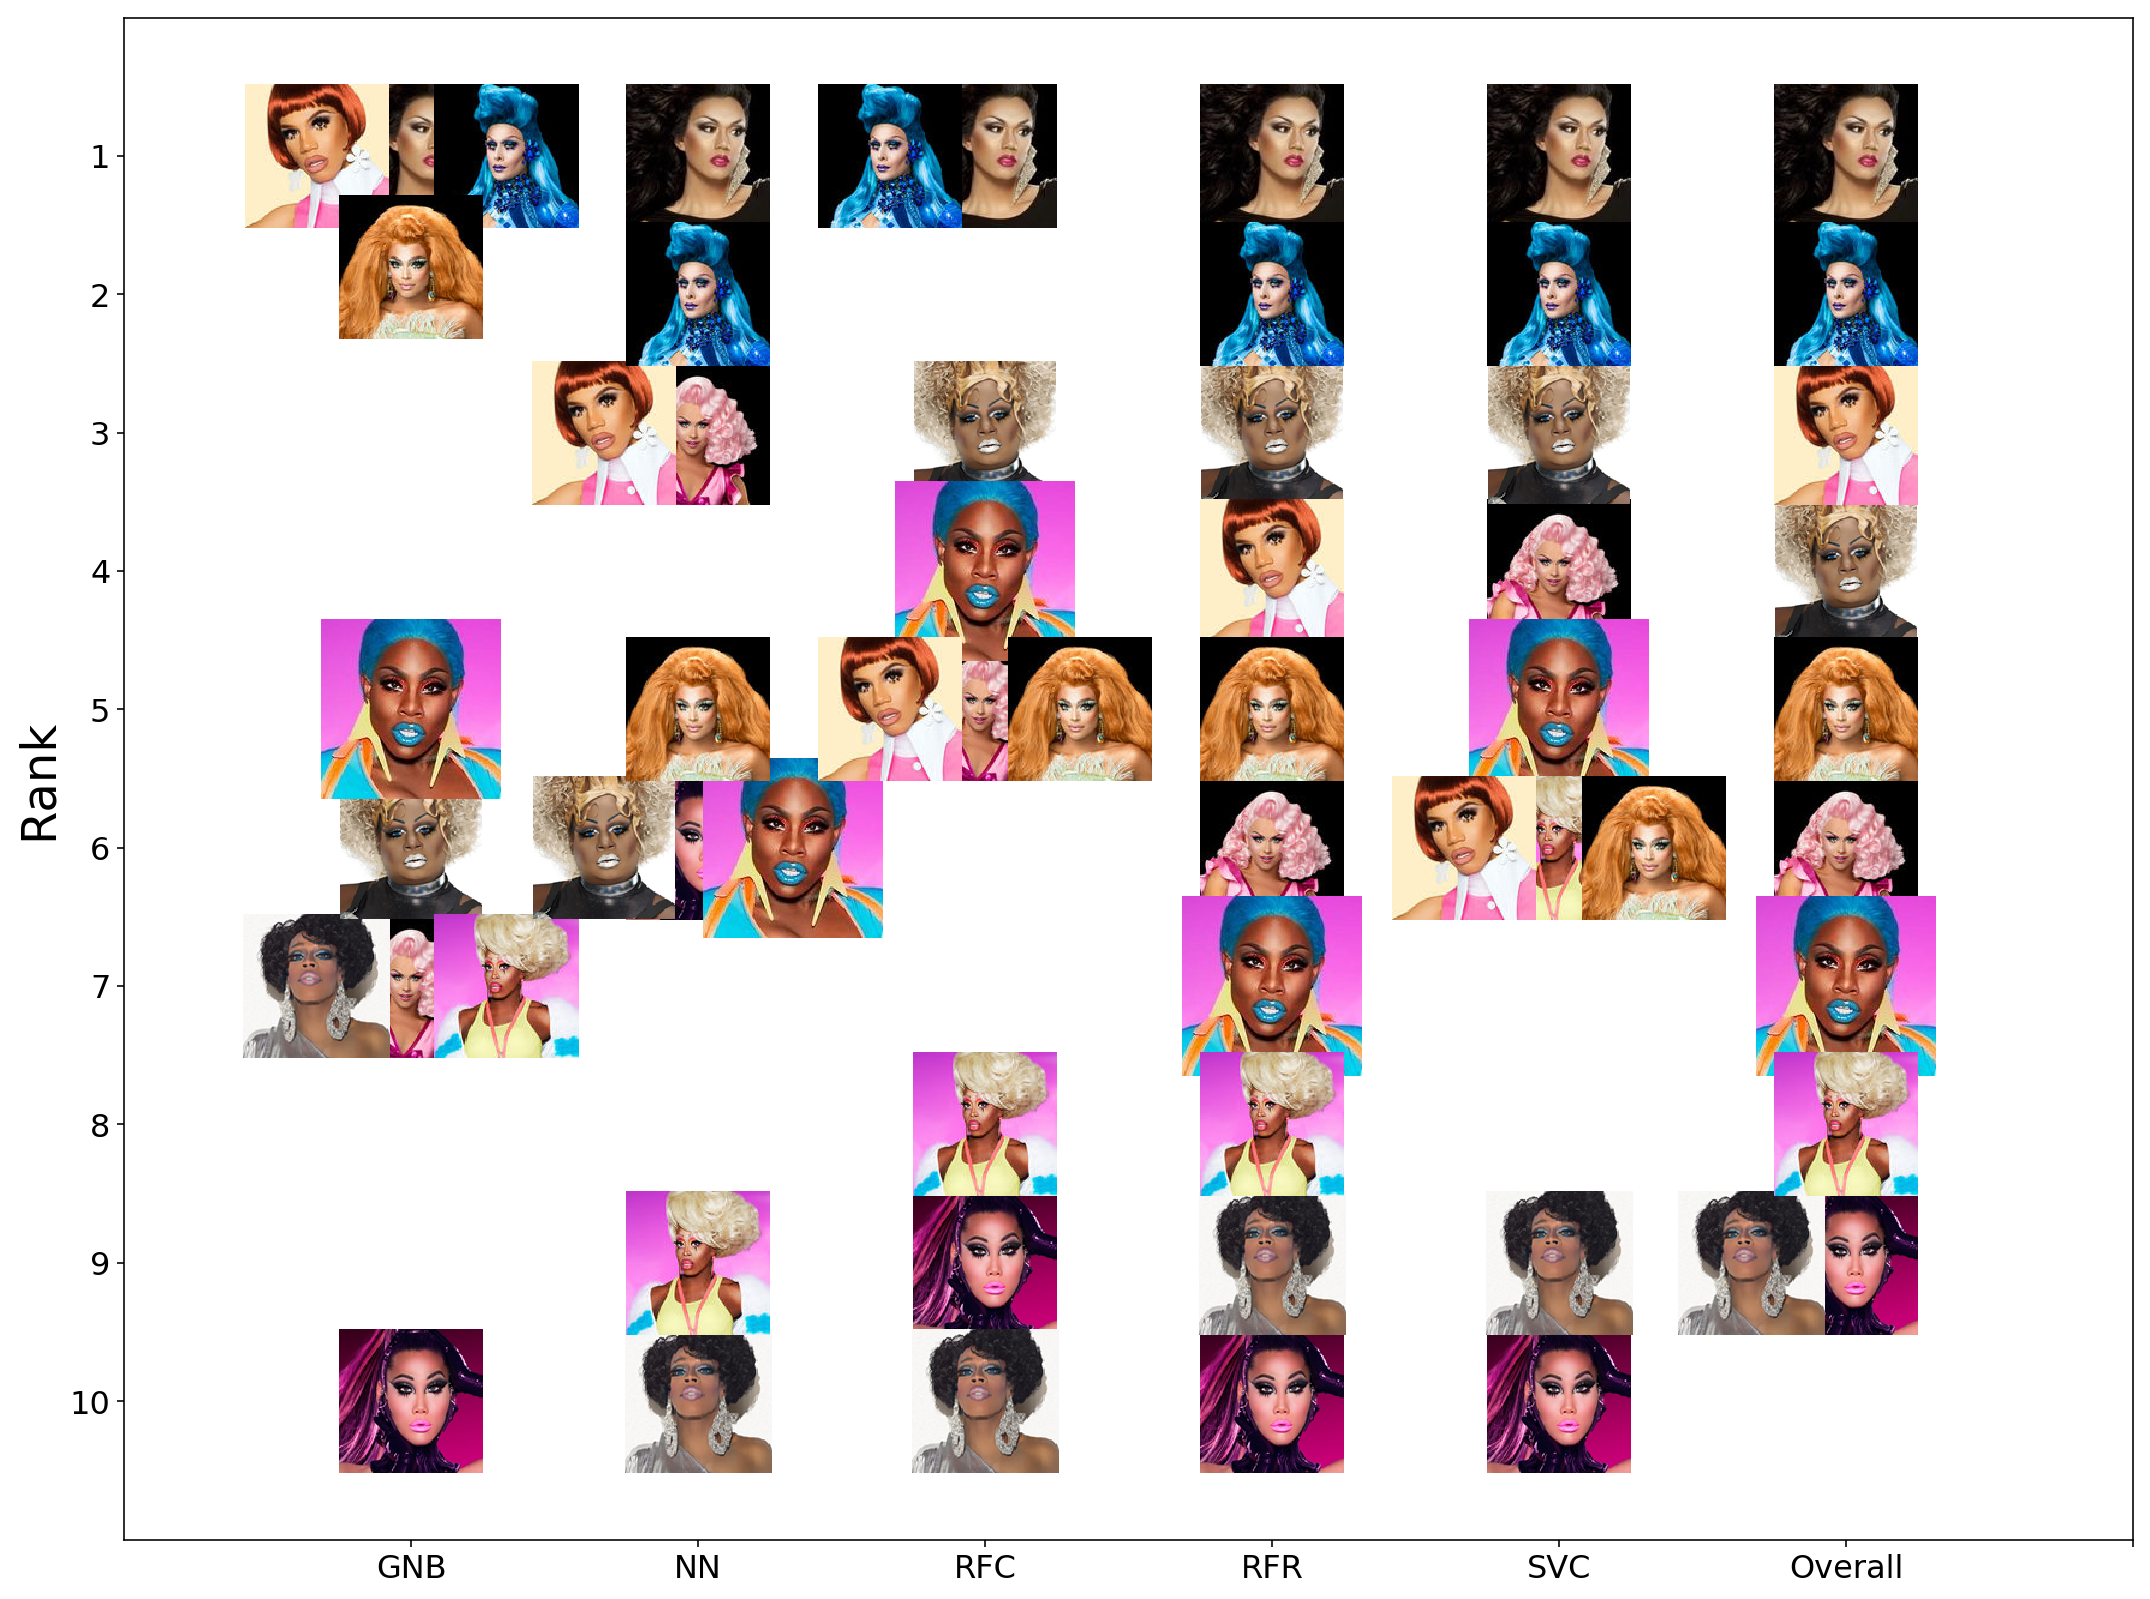

In [26]:
num_queens = 10

fig = plt.figure(figsize=(18,14))
ax = fig.add_subplot(1,1,1)
plt.xticks(range(7), ['GNB','NN','RFC','RFR','SVC','Overall'], size='small')
plt.yticks(range(num_queens),range(num_queens,0,-1))
ax.set_ylim([-1,num_queens])
ax.set_xlim([-1,6])
ax.set_ylabel("Rank",fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=16)

models = ['GNB','NN','RFC','RFR','SVC']

for i in range(5):
    the_data = AllStars
    places = {}
    for name in the_data.Name:
        file_name = name.replace(" ","").replace("'","") + "Mug.png"
        place = num_queens-np.asscalar(the_data.loc[the_data.Name==name,models[i]])
        if place in places.keys():
            places[place]+=1
        else:
            places[place]=1
        img = mpimg.imread("AllStars 4 Queens/"+file_name)
        im = OffsetImage(img,zoom=0.6)
        x, y = setXY(i,place,places[place])
        ab = AnnotationBbox(im,(x,y),xycoords='data',frameon=False)
        ax.add_artist(ab)

the_data = AllStars
places = {}
for name in the_data.Name:
    file_name = name.replace(" ","").replace("'","") + "Mug.png"
    place = num_queens-np.asscalar(the_data.loc[the_data.Name==name,'PredPlace'])
    if place in places.keys():
        places[place]+=1
    else:
        places[place]=1
    img = mpimg.imread("AllStars 4 Queens/"+file_name)
    im = OffsetImage(img,zoom=0.6)
    x, y = setXY(5,place,places[place])
    ab = AnnotationBbox(im,(x,y),xycoords='data',frameon=False)
    ax.add_artist(ab)



fig.savefig("predictedAS4.png")